# Iris Classification
## Table of Contents
- [A](#)
- [B](#)
- [C](#)
- [D](#)

### Import Libraries

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

### Load Data

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = pd.read_csv(url, names=names)

### Data Quality Check

In [4]:
# shape
print("Shape: ",dataset.shape,"\n")

Shape:  (150, 5) 



In [5]:
# head
print("First records of data:\n ",dataset.head(),"\n")

First records of data:
     sepal-length  sepal-width  petal-length  petal-width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa 



In [6]:
# class distribution
print(dataset.groupby('class').size())

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64


In [7]:
# Describe data frame
dataset.describe()

,sepal-length,sepal-width,petal-length,petal-width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


From the initial quality check, we observe a balanced data set with 150 flower inputs.  The distribution of the data set is concentrated with small standard deviation for the features sepal-length, sepal-width, and petal-width. Petal-length seems to have more variability. Let us explore the feature distributions.

## EDA 1: Feature Distributions + Scatter Plots

From the initial pairplot, we have learned Iris-setosa has distinct features compared to iris-versicolor and iris-virginica. Some features also seem to be correlated.

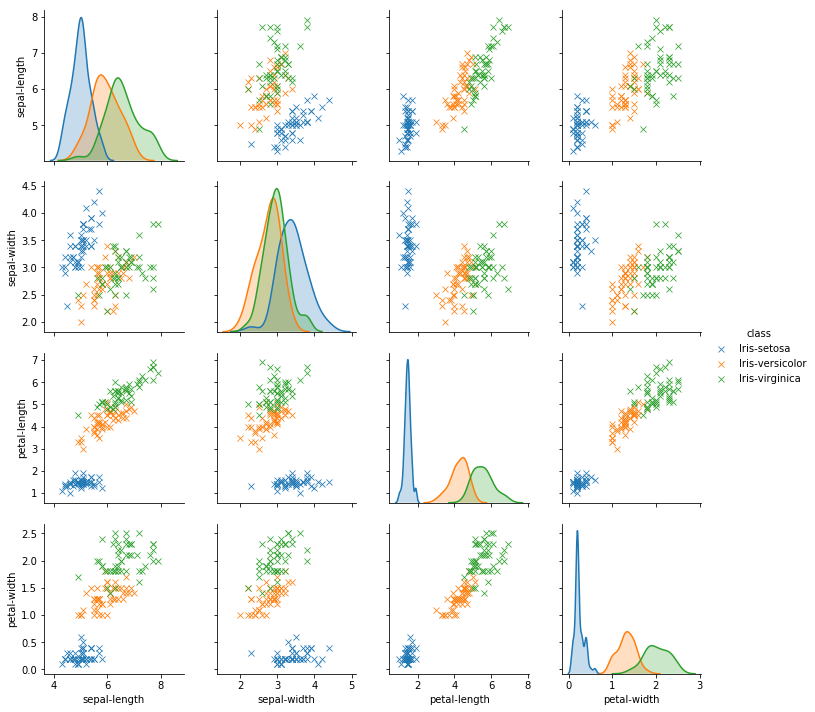

In [17]:
sns.pairplot(dataset, hue='class', markers='x')

## EDA 2: Exploring Correlated Features

Most of these features are correlated, which begs the question if these features are necessary. Can we reduce dimensionality to more accurately predict the correct iris?

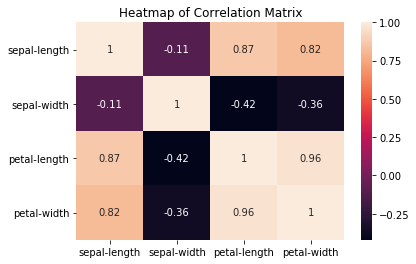

In [13]:
corr = dataset.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True)
plt.title('Heatmap of Correlation Matrix');

### PCA

The correlation matrix above suggested the importance of each feature. Thus, we can use PCA to hopefully reduce noise and better visualization. 

If we are to have two primary components, we observe these two components explain 95.7 of the variance. Thus, it'll be interesting to fit the model to the actual data vs these two primary components to compare the predictive power. 

On top of the variance explanation, we also see a better line separating versicolor and virginica 

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [25]:
X = dataset[names[:-1]]
X_scaled = StandardScaler().fit_transform(X)

In [28]:
pca= PCA(n_components=2)
pcomponents = pca.fit_transform(X_scaled)
pca.explained_variance_ratio_

array([0.72770452, 0.23030523])

In [47]:
dataset['class'] = pd.Categorical(dataset['class'])
dataset['code'] = dataset['class'].cat.codes

Text(0, 0.5, 'Second principle component')

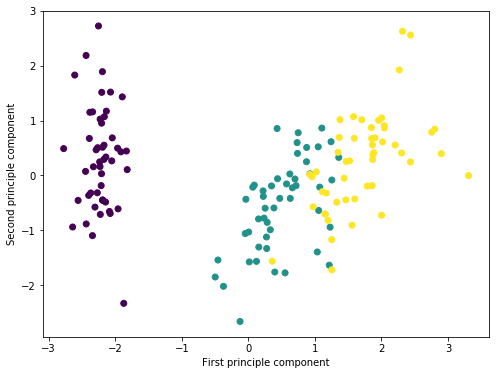

In [49]:
plt.figure(figsize=(8,6))
plt.scatter(pcomponents[:,0], pcomponents[:,1], c=dataset['code'])
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

We can see from the explained variance plot, 2 features is where the kink in the curve is.

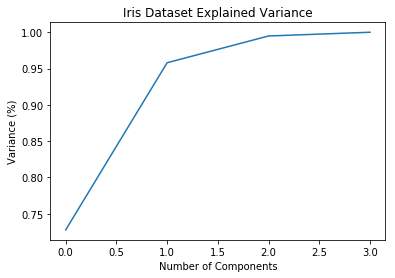

In [54]:
#Fitting the PCA algorithm with our Data
pca2 = PCA().fit(X_scaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Iris Dataset Explained Variance')
plt.show()

## Pre-Processing

We need to separate the data with train_test_split to obtain train/test data to train and fit our model.

We will also be scaling our data with StandardScaler

In [61]:
from sklearn.model_selection import train_test_split 

X = dataset[names[:-1]]
X_scaled = StandardScaler().fit_transform(X)
y = dataset['code']
# Scaled data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)
# PC data
X_train_pc, X_test_pc, y_train_pc, y_test_pc = train_test_split(pcomponents,y,test_size=0.20, random_state=123)

## Training Models
1. Logistic Regression
2. K-Nearesst Neighbor
2. SVM
3. Random Forest
4. Gradient Boosting Classifier

From the initial model fit, we can see that more features does give a better fit. Having correlated features does not matter for a better fit in this particular case.

In [72]:
import warnings
warnings.filterwarnings("ignore")

In [68]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [83]:
# Test options and evaluation metric (PC)
seed = 7
scoring = 'accuracy'

results = []
names = []

# evaluate each model in turn
for name, model in models:
    kfold = model_selection.KFold(n_splits=20, random_state=seed)
    cv_results = model_selection.cross_val_score(model, 
                                                 X_train, 
                                                 y_train, 
                                                 cv=kfold, 
                                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.958333 (0.089365)
KNN: 0.975000 (0.059512)
SVM: 0.975000 (0.079495)
RF: 0.933333 (0.097183)
GB: 0.941667 (0.095379)


In [86]:
# Test options and evaluation metric (PC)
seed = 7
scoring = 'accuracy'

results_pc = []
names = []

# evaluate each model in turn
for name, model in models:
    kfold = model_selection.KFold(n_splits=20, random_state=seed)
    cv_results_pc = model_selection.cross_val_score(model, 
                                                 X_train_pc, 
                                                 y_train_pc, 
                                                 cv=kfold, 
                                                 scoring=scoring)
    results_pc.append(cv_results_pc)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results_pc.mean(), cv_results_pc.std())
    print(msg)

LR: 0.833333 (0.129099)
KNN: 0.925000 (0.082916)
SVM: 0.925000 (0.082916)
RF: 0.900000 (0.097183)
GB: 0.900000 (0.097183)


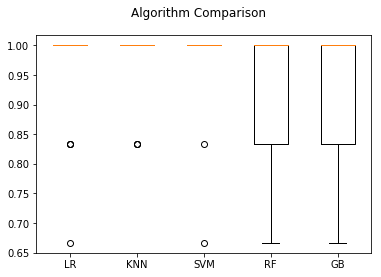

In [89]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

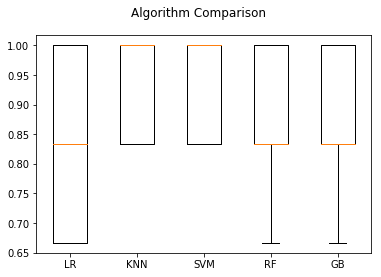

In [88]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_pc)
ax.set_xticklabels(names)
plt.show()